In [2]:
import autoreload
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from make_video import make_video, parser
import ray
import shutil
from IPython.display import display, FileLink
from matplotlib import pyplot as plt
from analysis_helpers import get_videos, get_scores, concat_videos, VideosDownloader, get_df_from_logdir
import numpy as np
import pickle
from bursts_analysis import burst_background, burst_line_plot, cols, burst_sizes, fill_which_training, iterate_bursts

In [3]:
# need ray for parallel evaluation
ray.shutdown()
ray.init(num_cpus=28, ignore_reinit_error=True, log_to_driver=False)

2020-10-22 06:25:06,809	INFO resource_spec.py:212 -- Starting Ray with 54.0 GiB memory available for workers and up to 27.02 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-22 06:25:07,056	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-22 06:25:07,304	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:6379',
 'object_store_address': '/tmp/ray/session_2020-10-22_06-25-06_806679_19777/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-22_06-25-06_806679_19777/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-10-22_06-25-06_806679_19777'}

In [4]:
# loading data
exp_name = "adversarial_tune_bursts_exp_withnormal_1adv_sb"
config = "bursts_exp_withnormal_1adv_sb"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)

In [5]:
SCORE_STEPS = 1# 15
VIDEO_STEPS = 1# 15

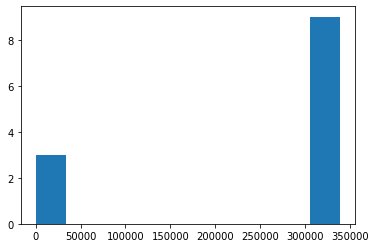

In [6]:
# removing short trials
plt.hist(df['episodes_total'])
df = df[df.episodes_total > 100000]

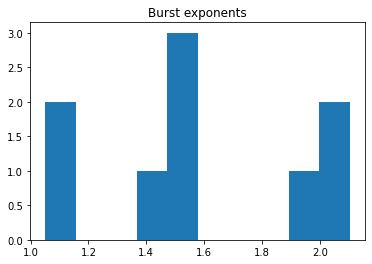

In [7]:
# All exponents
plt.title("Burst exponents")
plt.hist(df['config/_burst_exponent'])
plt.show()

In [8]:
def process_trial_dataframe(rdf, fn="experiment"):


    # List of all players
    reward_prefix = 'policy_reward_mean/'
    POLICIES = [x[len(reward_prefix):] for x in rdf.columns if x.startswith(reward_prefix)]
    print("Policies:", POLICIES)

    exponent = rdf['config/_burst_exponent'][0]
    print("Exponent:", exponent)

    # filling the 'which_training' column
    rdf = fill_which_training(rdf, POLICIES)
    burst_sizes_ = burst_sizes(rdf['which_training'])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Which player is trained?")
    plt.plot(rdf['timesteps_total'], rdf['which_training'])
    plt.xlabel('Timesteps')
    plt.subplot(1, 2, 2)
    plt.title(f"Burst sizes with exponent {round(exponent, 2)}")
    plt.plot(burst_sizes_)
    plt.xlabel('Burst number')
    plt.ylabel('Burst size')
    plt.savefig(fn + "_bursts.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.startswith(reward_prefix)]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10},
                   min_size=0)

    plt.legend()
    plt.savefig(fn + "_reward.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.xlabel('Timesteps')

    fields = [x for x in rdf.columns if x.endswith('value_loss')]

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10},
                   min_size=0)

    plt.legend()
    plt.savefig(fn + "_loss.png", bbox_inches='tight')
    plt.show()


    # was there a switch?
    rdf['switch'] = list(np.array(rdf['which_training'].iloc[1:]) != rdf['which_training'].iloc[:-1]) + [True]

    rdf_e = rdf[rdf['switch'] == 1]
    print("To evaluate", len(rdf_e))

    # obtaining the scores


    scores = get_scores(rdf_e, steps=SCORE_STEPS, load_normal=False, config=config)

    POLICIES_SHOW = list(POLICIES)
    if len(POLICIES_SHOW) == 2:
        POLICIES_SHOW = POLICIES_SHOW[0:1]

    # plotting the win rate
    plt.title("Win rate")
    for p in POLICIES_SHOW:
        plt.plot(rdf_e['timesteps_total'], [x.get(f"wins_policy_{p}_reward", -1) for x in scores], label=p + '_adversarial')
        plt.scatter(rdf_e['timesteps_total'][0], [x.get(f"wins_policy_{p}_reward", -1) for x in scores][0])
        assert all([x.get(f"ties_policy_{p}_reward", 0) == 0 for x in scores])
    plt.xlabel("Time-steps")

    iterate_bursts(rdf, burst_background, state={'min_metric': 0, 'max_metric': 100}, min_size=0)

    plt.legend()
    plt.savefig(fn + "_win_rate.png", bbox_inches='tight')

    plt.show()

    videos = get_videos(rdf_e, steps=VIDEO_STEPS, load_normal=False, config=config)

    result = {'scores': scores, 'videos': videos,
              'xs_e': rdf_e['timesteps_total'],
              'policies': POLICIES,
              'burst_sizes': burst_sizes_,
              'rdf': rdf,
              'rdf_e': rdf_e
             }
    
    return result

100%|██████████| 2972/2972 [00:02<00:00, 1423.51it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.0514132676968575


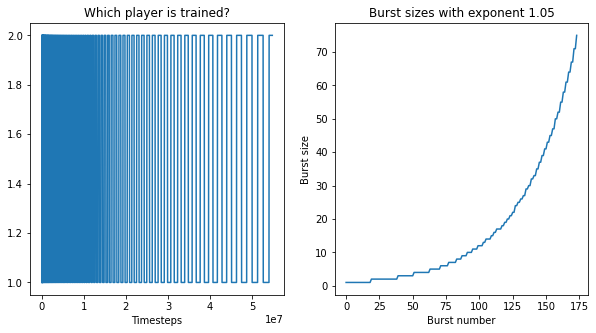

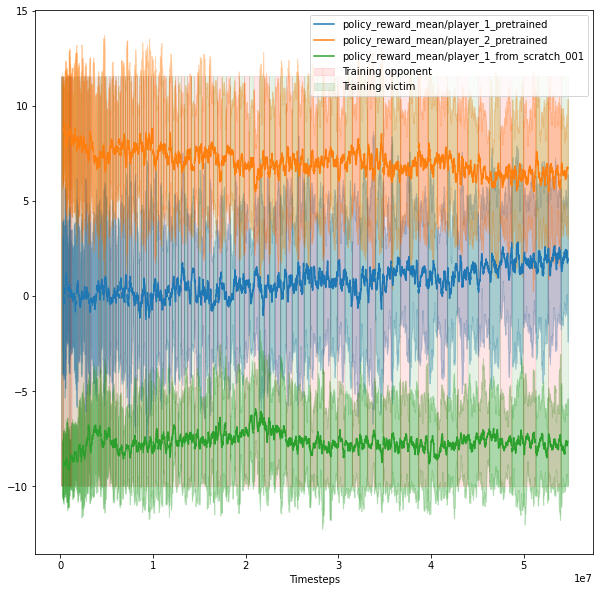

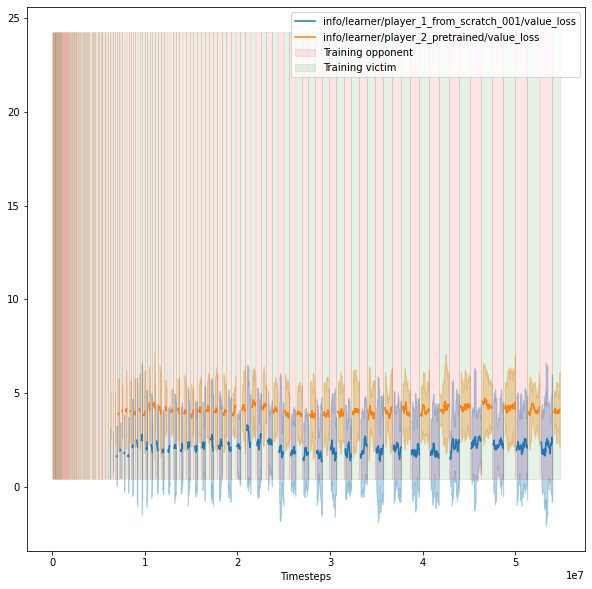

To evaluate 174


In [ ]:
trial = df.iloc[0]
rdf = get_df_from_logdir(trial.logdir)
res = process_trial_dataframe(rdf)

In [10]:
SCORE_STEPS = 15
VIDEO_STEPS = 3

100%|██████████| 2972/2972 [00:02<00:00, 1446.42it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.0514132676968575


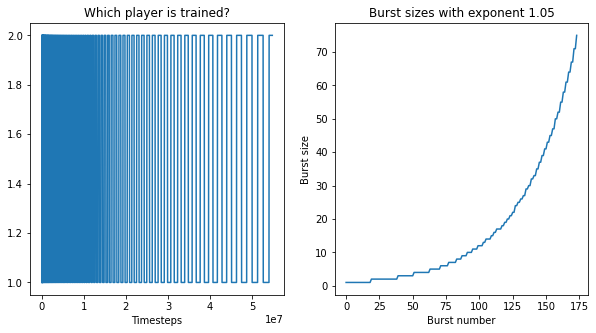

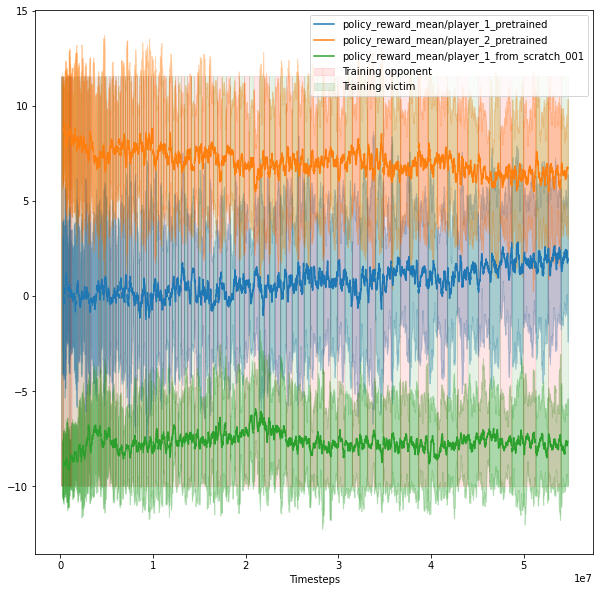

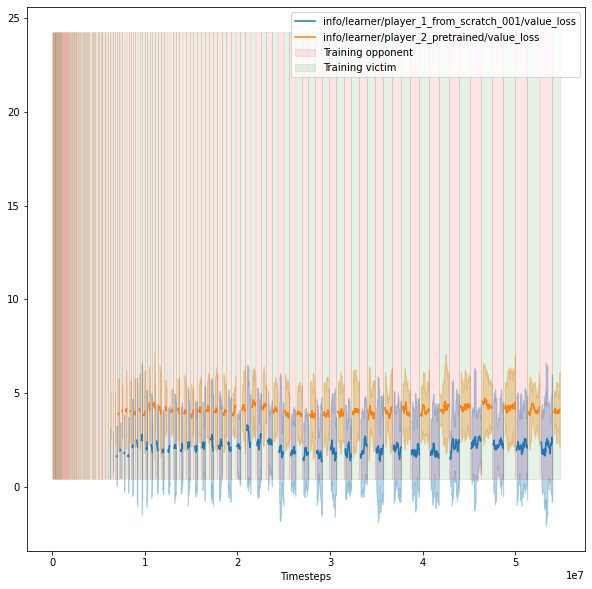

To evaluate 174


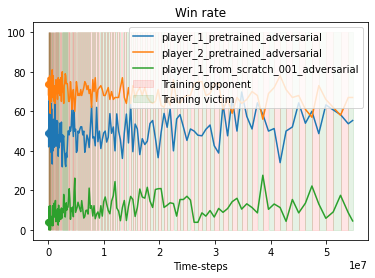

100%|██████████| 2958/2958 [00:02<00:00, 1264.67it/s]


Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 1.4755946832465987


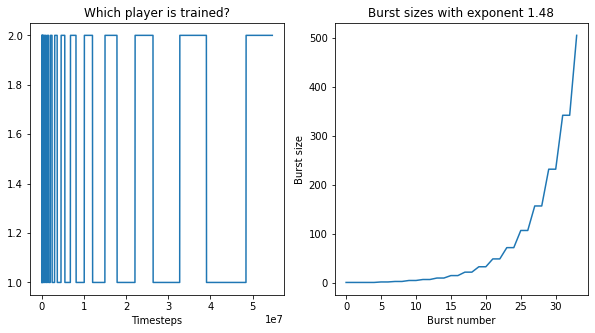

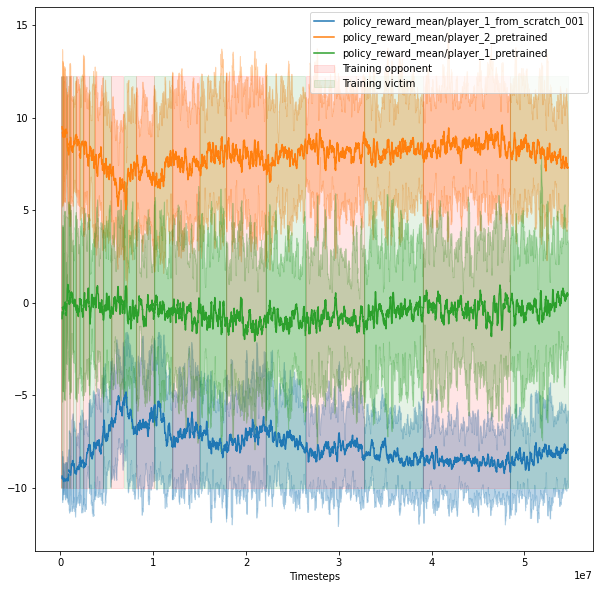

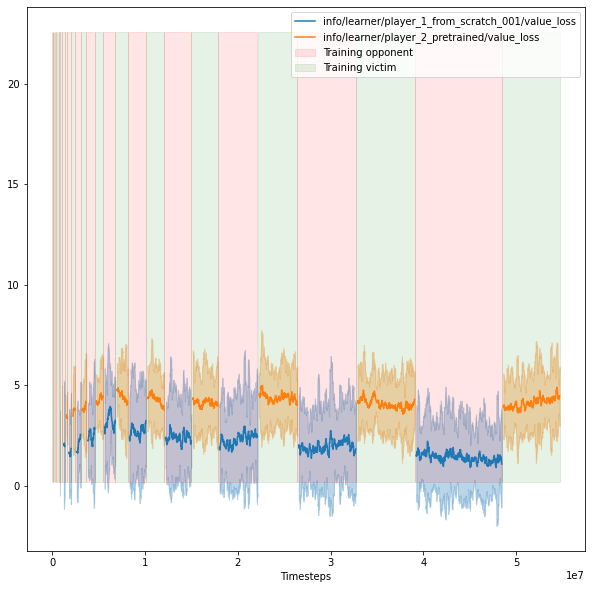

To evaluate 34


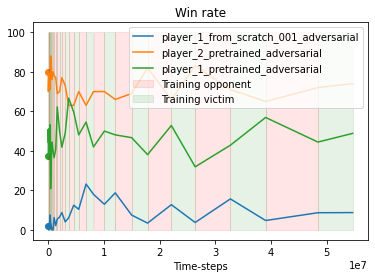

100%|██████████| 2939/2939 [00:02<00:00, 1420.90it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 2.0112751003119484


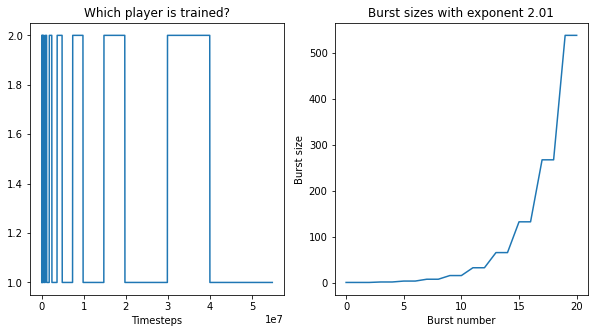

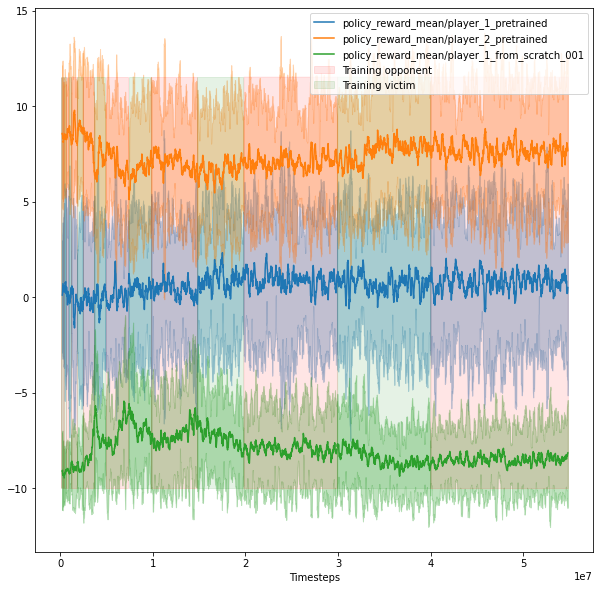

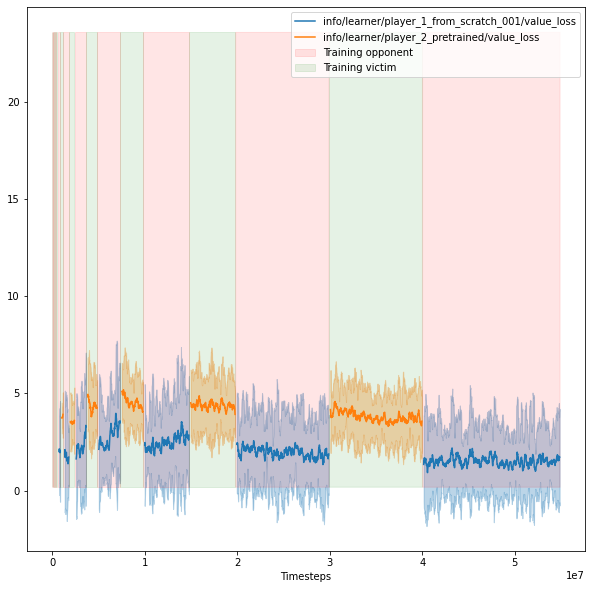

To evaluate 21


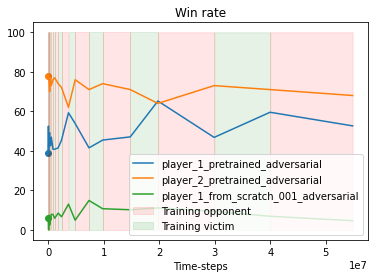

100%|██████████| 2948/2948 [00:02<00:00, 1447.67it/s]


Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 1.4855370350428745


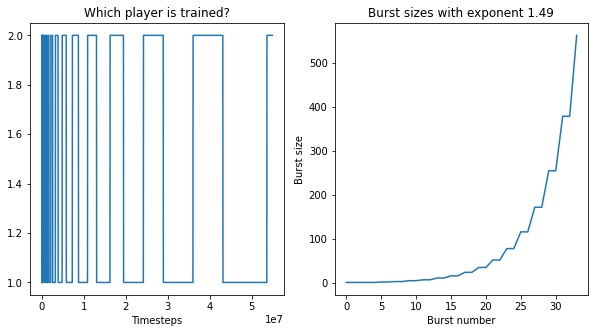

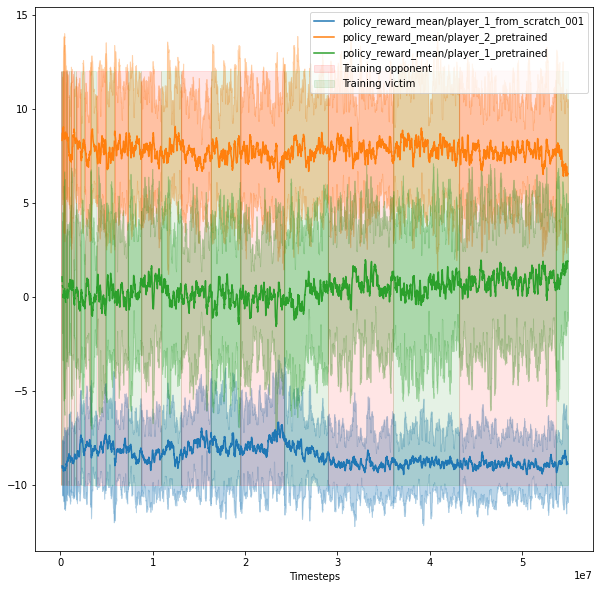

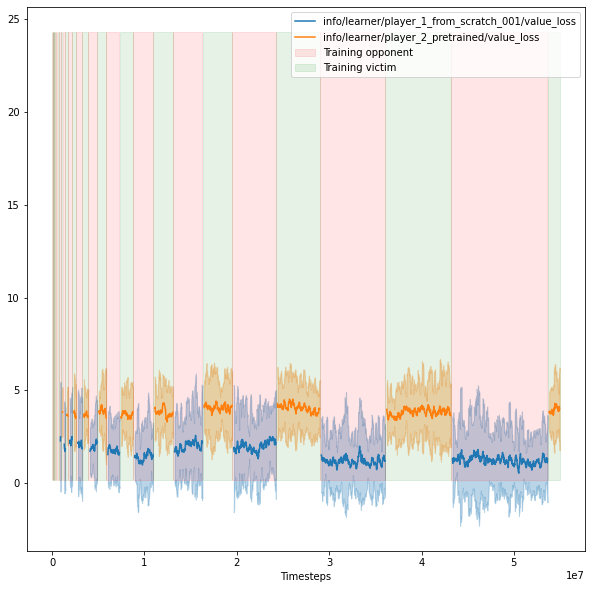

To evaluate 34


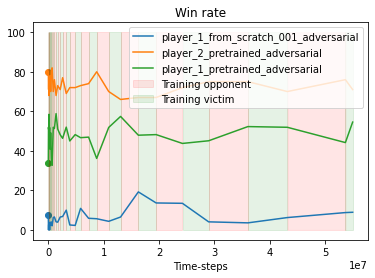

100%|██████████| 2933/2933 [00:02<00:00, 1442.17it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.1056073678904241


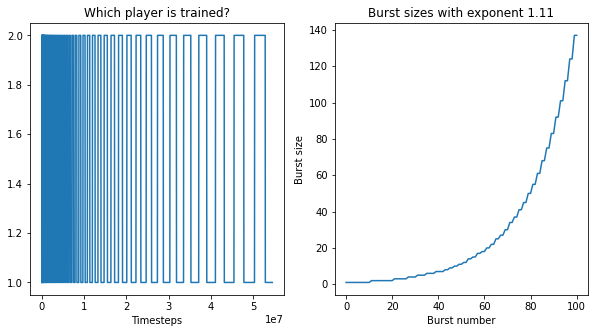

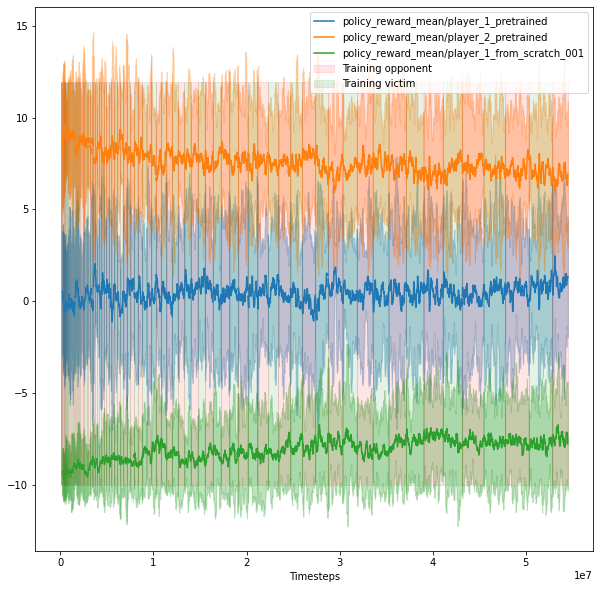

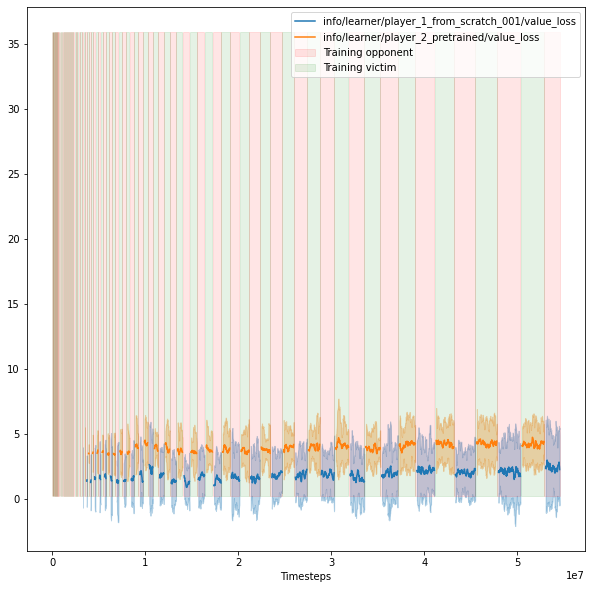

To evaluate 101


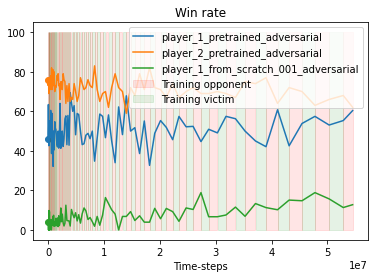

100%|██████████| 2960/2960 [00:02<00:00, 1255.32it/s]


Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 2.1032864746574202


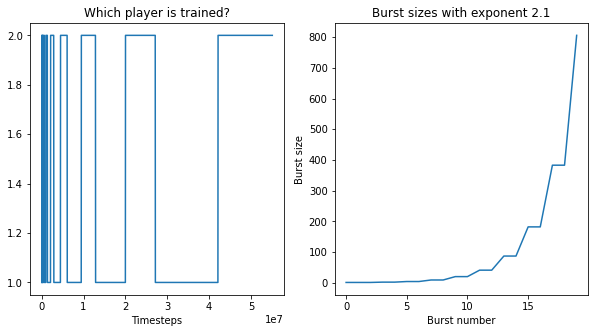

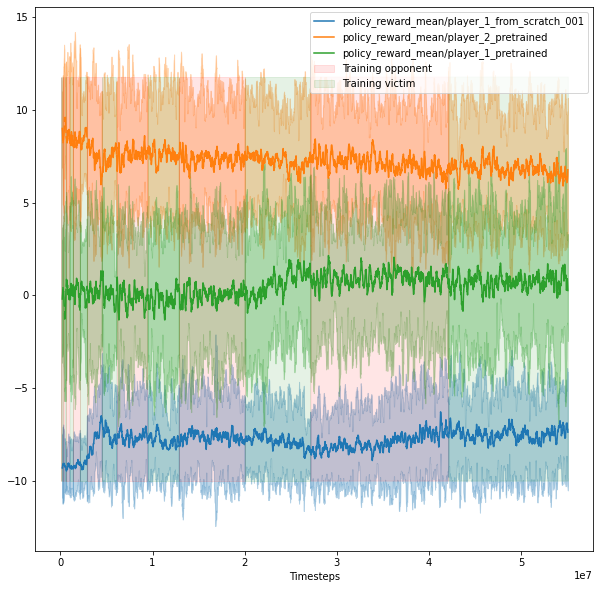

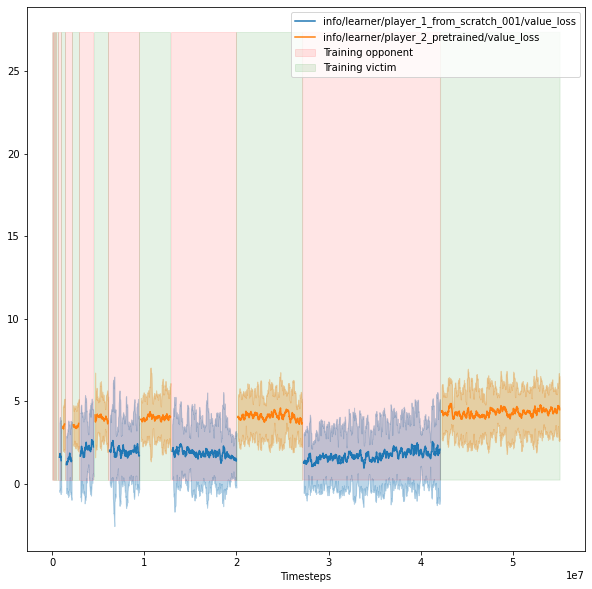

To evaluate 20


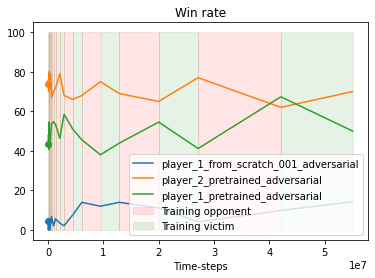

100%|██████████| 2967/2967 [00:02<00:00, 1445.14it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.5479851392712682


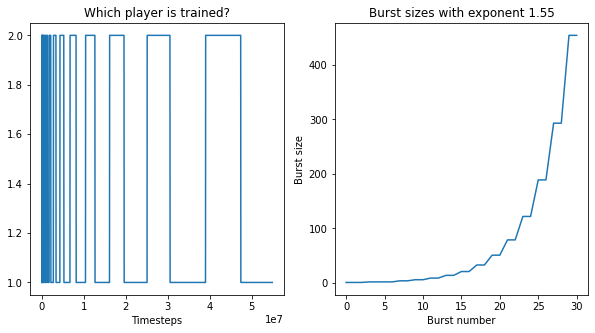

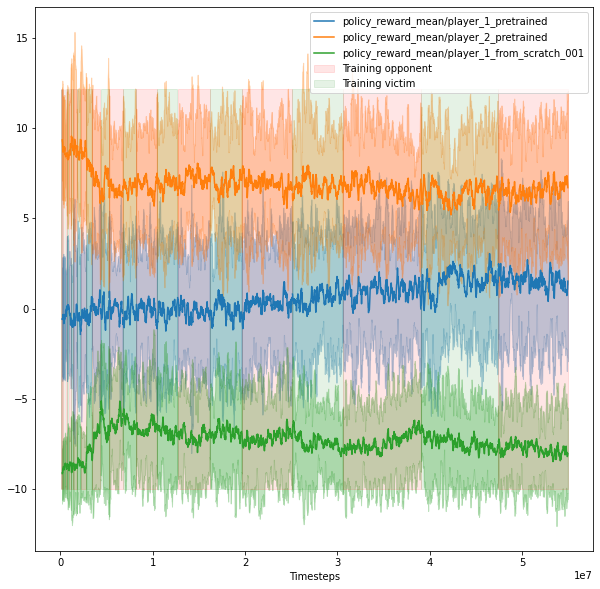

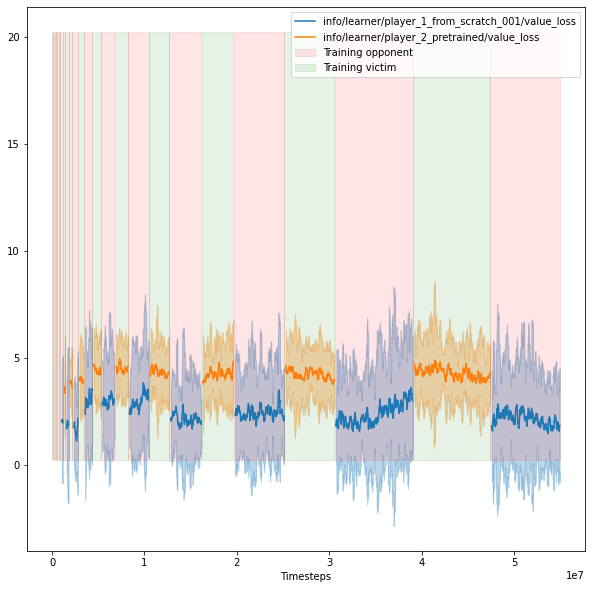

To evaluate 31


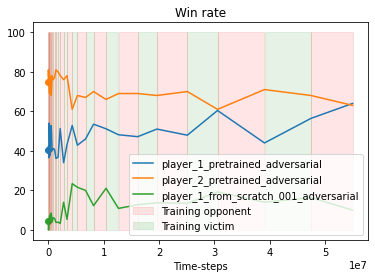

100%|██████████| 2934/2934 [00:02<00:00, 1444.38it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.428148581767143


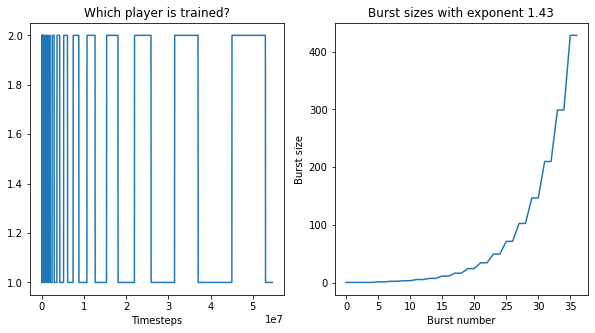

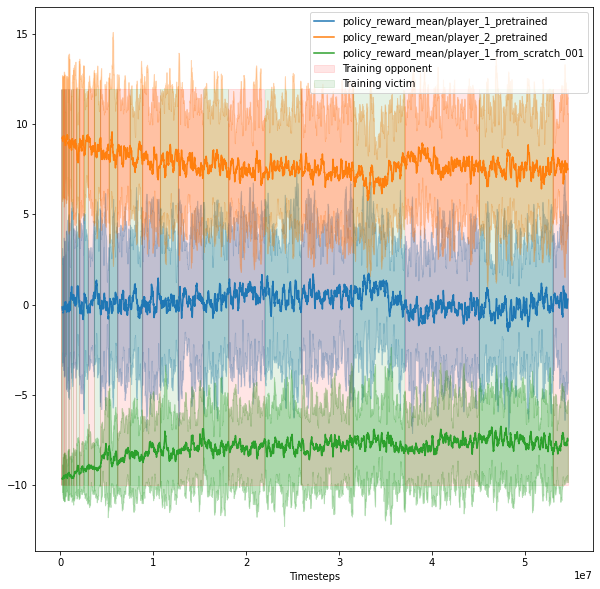

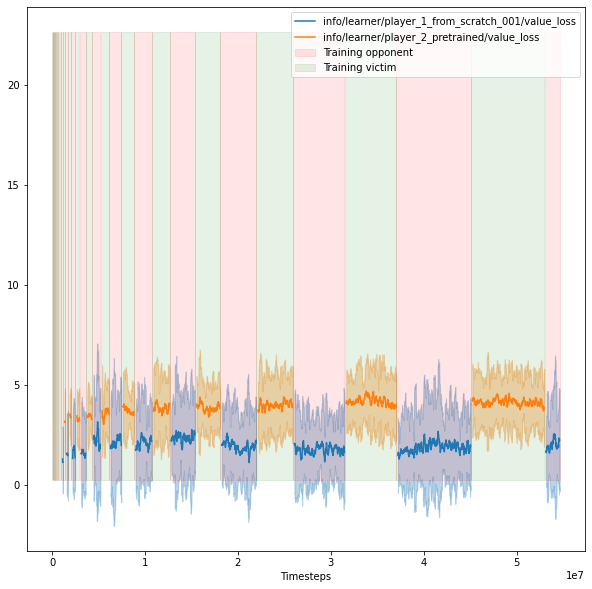

To evaluate 37


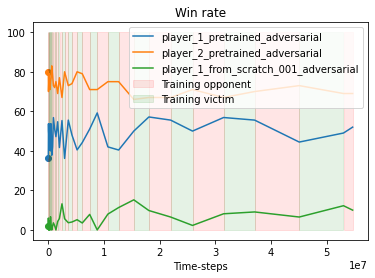

100%|██████████| 2983/2983 [00:02<00:00, 1457.45it/s]


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.9925118540024604


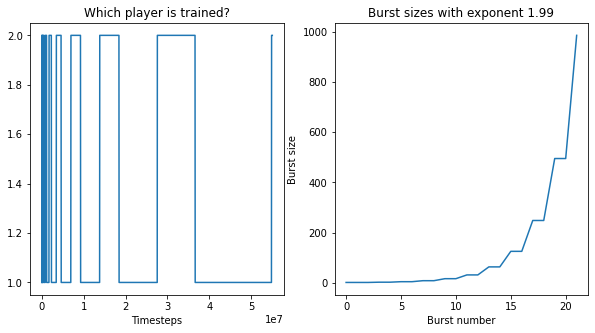

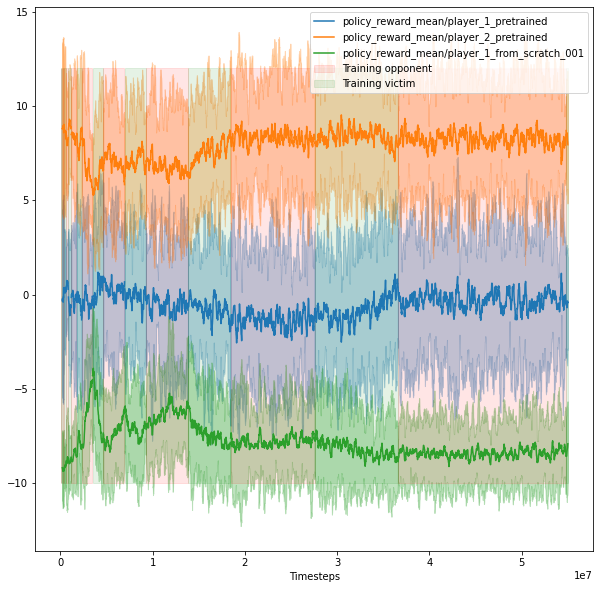

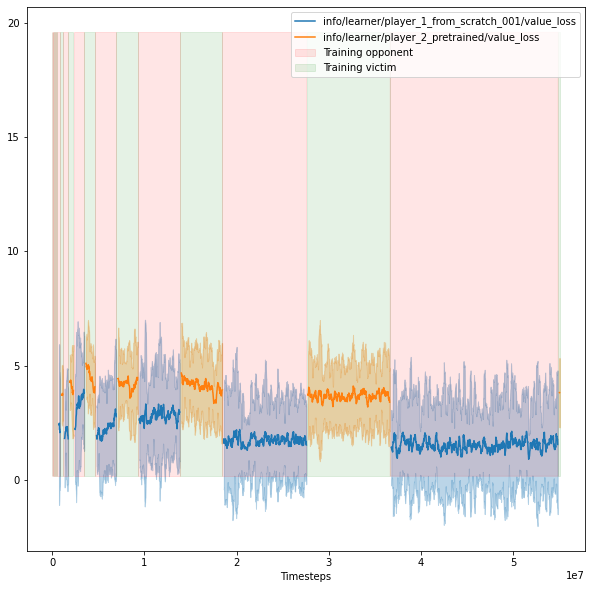

To evaluate 22


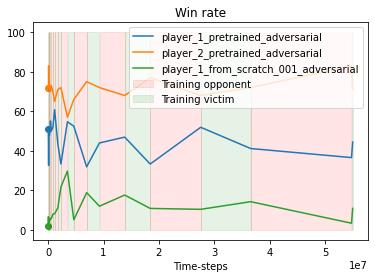

In [11]:
fns = []

for i, trial in df.iterrows():
    rdf = get_df_from_logdir(trial.logdir)
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = process_trial_dataframe(rdf, fn)
    
    pickle.dump(res, open(fn, "wb"))
    fns.append(fn)

In [14]:
from tqdm import tqdm

In [17]:
with VideosDownloader() as vd:

    for i, trial in tqdm(df.iterrows()):
        fn = f"{exp_name}_trial_{str(i)}.pkl"
        res = pickle.load(open(fn, "rb"))

        if 'videos_normal' in res:
            for j, video in enumerate(res['videos_normal']):
                vd.add_video(video, "trial_normal_%05d_ts_%09d.mp4" % (i, res['rdf_e'].timesteps_total.iloc[j]))

        if 'videos' in res:
            for j, video in enumerate(res['videos']):
                vd.add_video(video, "trial_advers_%05d_ts_%09d.mp4" % (i, res['rdf_e'].timesteps_total.iloc[j]))

9it [00:02,  4.02it/s]


/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/videos.zip

Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.0514132676968575
Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 1.4755946832465987


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 2.0112751003119484


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 1.4855370350428745


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.1056073678904241


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_from_scratch_001', 'player_2_pretrained', 'player_1_pretrained']
Exponent: 2.1032864746574202


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.5479851392712682


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.428148581767143


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Policies: ['player_1_pretrained', 'player_2_pretrained', 'player_1_from_scratch_001']
Exponent: 1.9925118540024604


/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/scratch/sergei/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


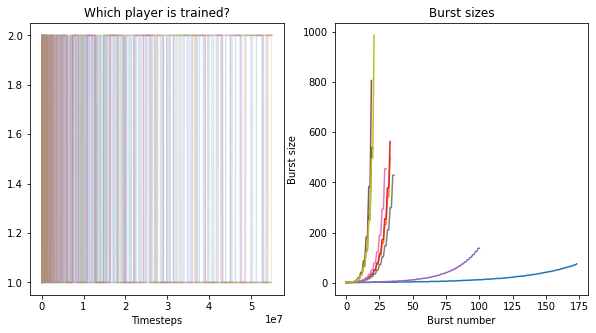

In [18]:
plt.figure(figsize=(10, 5))
for i, trial in df.iterrows():
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = pickle.load(open(fn, "rb"))
    rdf = res['rdf']
    
    # List of all players
    reward_prefix = 'policy_reward_mean/'
    POLICIES = [x[len(reward_prefix):] for x in rdf.columns if x.startswith(reward_prefix)]
    print("Policies:", POLICIES)

    exponent = rdf['config/_burst_exponent'][0]
    print("Exponent:", exponent)

    # filling the 'which_training' column
    rdf = fill_which_training(rdf, POLICIES)
    burst_sizes_ = burst_sizes(rdf['which_training'])
    
    plt.subplot(1, 2, 1)
    plt.title("Which player is trained?")
    plt.plot(rdf['timesteps_total'], rdf['which_training'], alpha=0.2)
    plt.xlabel('Timesteps')
    plt.subplot(1, 2, 2)
    plt.title(f"Burst sizes")
    plt.plot(burst_sizes_)
    plt.xlabel('Burst number')
    plt.ylabel('Burst size')
plt.show()

To evaluate 174


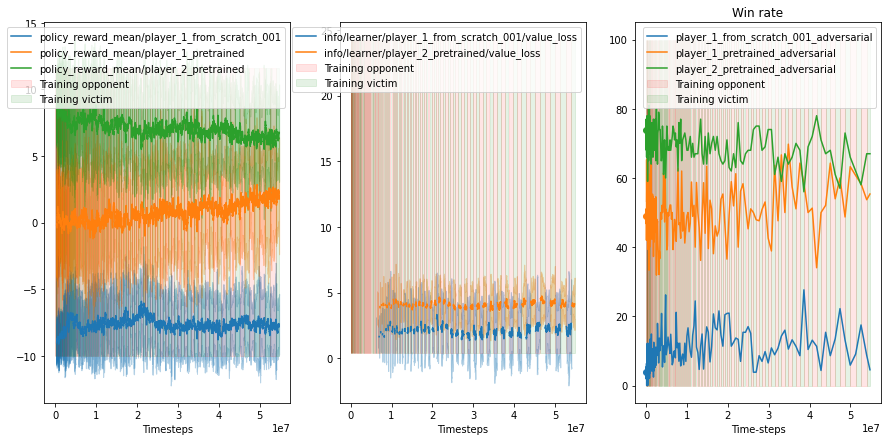

To evaluate 34


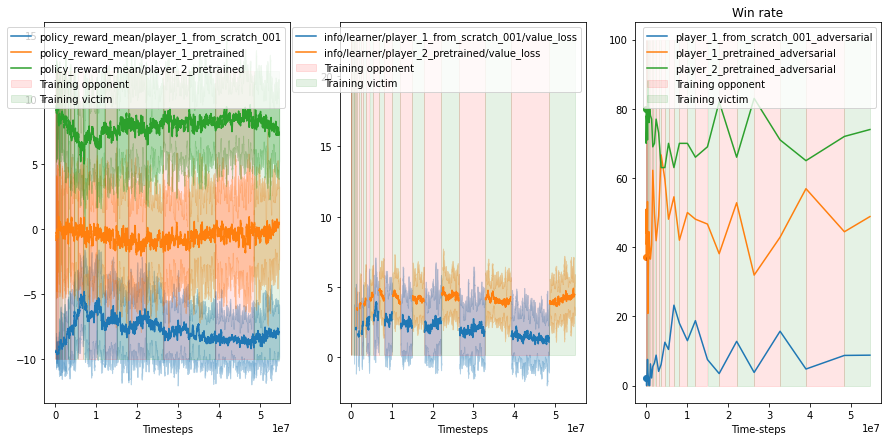

To evaluate 21


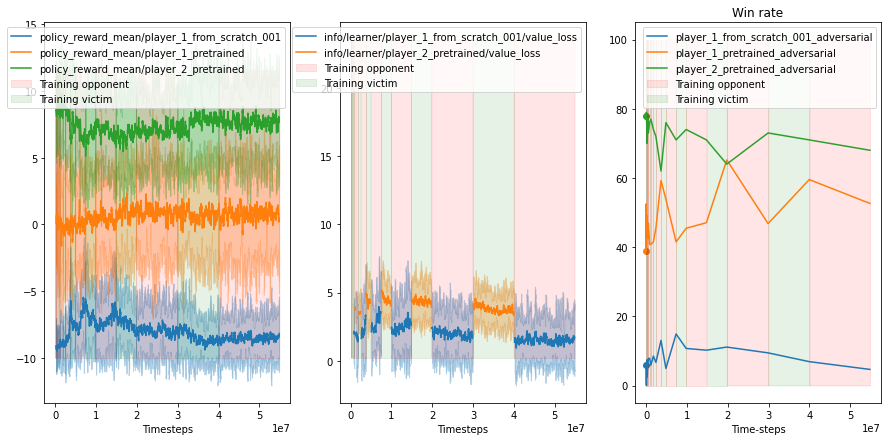

To evaluate 34


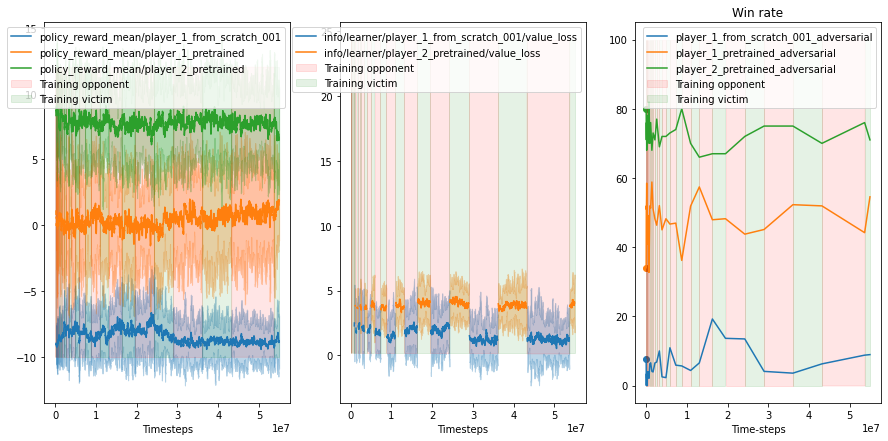

To evaluate 101


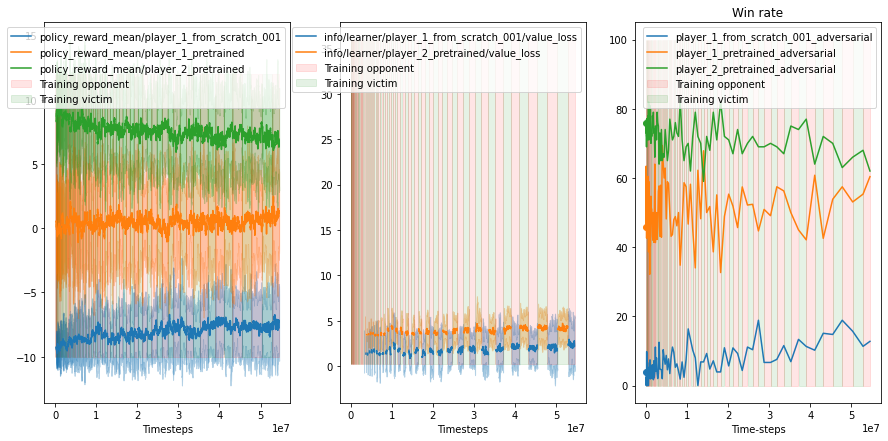

To evaluate 20


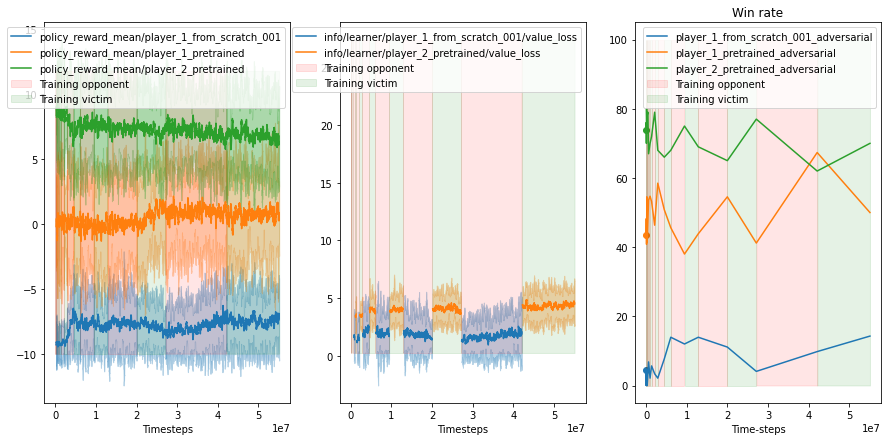

To evaluate 31


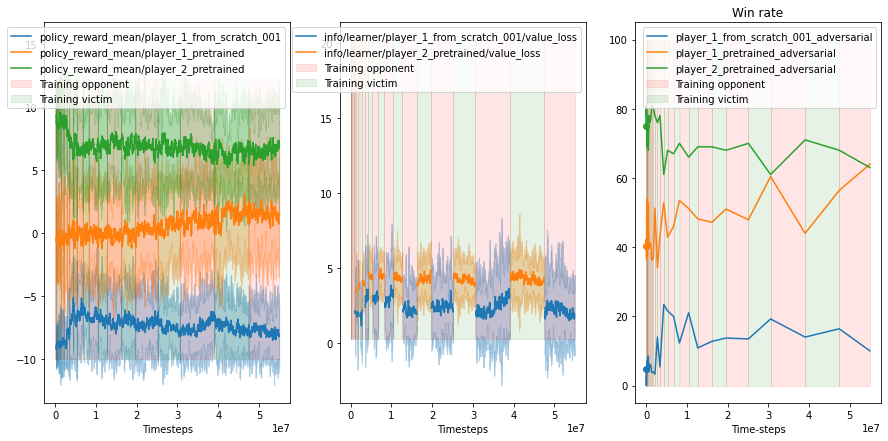

To evaluate 37


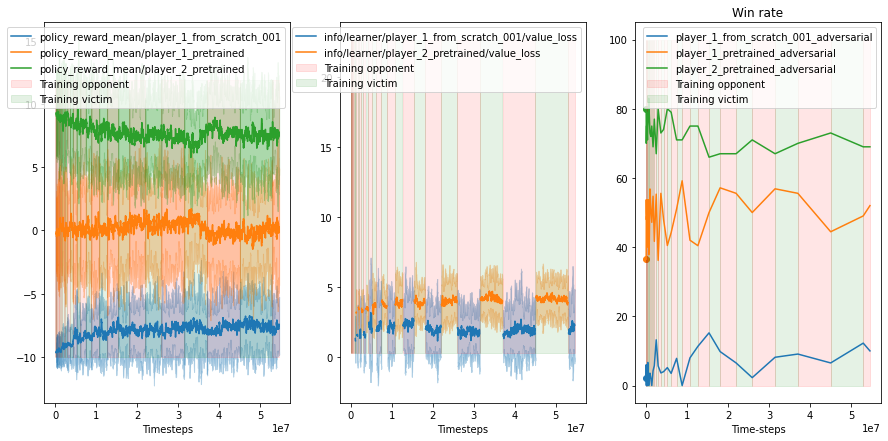

To evaluate 22


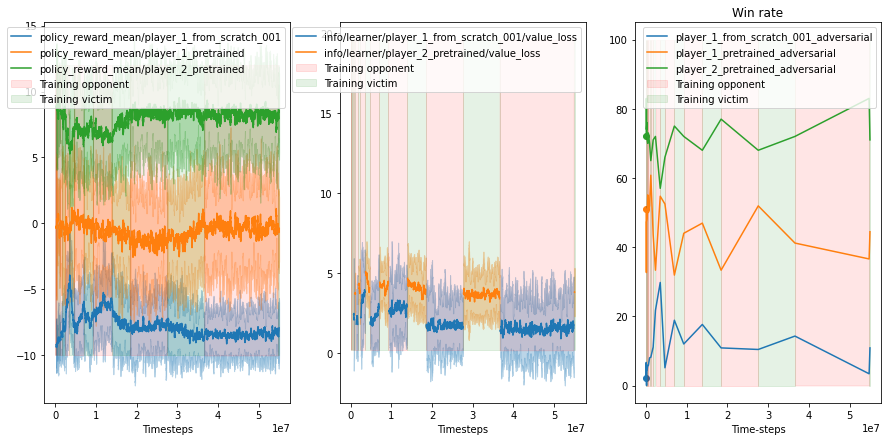

In [21]:
for i, trial in df.iterrows():
    fn = f"{exp_name}_trial_{str(i)}.pkl"
    res = pickle.load(open(fn, "rb"))
    rdf = res['rdf']

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.xlabel('Timesteps')

    fields = sorted([x for x in rdf.columns if x.startswith(reward_prefix)])

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10},
                   min_size=0)

    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.xlabel('Timesteps')

    fields = sorted([x for x in rdf.columns if x.endswith('value_loss')])

    iterate_bursts(rdf, burst_line_plot, state={'fields': fields,
                                                'colors': {f: cols[i] for i, f in enumerate(fields)},
                                                'rolling': 10},
                   min_size=0)

    plt.legend()
    plt.subplot(1, 3, 3)

    # was there a switch?
    rdf['switch'] = list(np.array(rdf['which_training'].iloc[1:]) != rdf['which_training'].iloc[:-1]) + [True]

    rdf_e = rdf[rdf['switch'] == 1]
    print("To evaluate", len(rdf_e))

    # obtaining the scores


    scores = res['scores']

    POLICIES_SHOW = list(POLICIES)
    if len(POLICIES_SHOW) == 2:
        POLICIES_SHOW = POLICIES_SHOW[0:1]

    # plotting the win rate
    plt.title("Win rate")
    for p in sorted(POLICIES_SHOW):
        plt.plot(rdf_e['timesteps_total'], [x[f"wins_policy_{p}_reward"] for x in scores], label=p + '_adversarial')
        plt.scatter(rdf_e['timesteps_total'][0], [x[f"wins_policy_{p}_reward"] for x in scores][0])
        assert all([x[f"ties_policy_{p}_reward"] == 0 for x in scores])
    plt.xlabel("Time-steps")

    iterate_bursts(rdf, burst_background, state={'min_metric': 0, 'max_metric': 100}, min_size=0)

    plt.legend()
    plt.show()

In [28]:
def get_data(f):
    for i, trial in df.iterrows():
        fn = f"{exp_name}_trial_{str(i)}.pkl"
        res = pickle.load(open(fn, "rb"))
        yield f(res)
        
def get_data_win_rate():
    def f(res):
        return {'exponent': res['rdf']['config/_burst_exponent'][0],
                'win_normal': res['scores'][-1]['wins_policy_player_1_pretrained_reward'],
                'win_adversary': res['scores'][-1]['wins_policy_player_1_from_scratch_001_reward'],
               }
    return pd.DataFrame(list(get_data(f)))

In [29]:
win_df = get_data_win_rate()

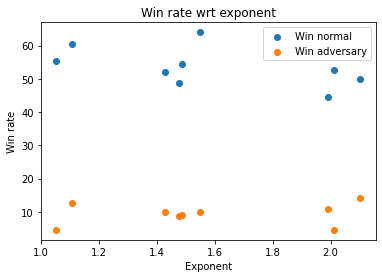

In [30]:
plt.title("Win rate wrt exponent")
plt.scatter(win_df['exponent'], win_df['win_normal'], label='Win normal')
plt.scatter(win_df['exponent'], win_df['win_adversary'], label='Win adversary')
plt.xlabel('Exponent')
plt.ylabel('Win rate')
plt.legend()
plt.show()

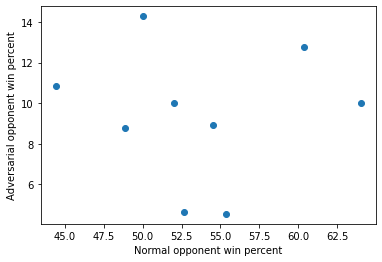

In [34]:
plt.scatter(win_df['win_normal'], win_df['win_adversary'])
plt.xlabel('Normal opponent win percent')
plt.ylabel('Adversarial opponent win percent')
plt.show()